In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle as pkl
from datetime import datetime, timedelta, time
from glob import glob
import sahara_work as sw
import dask.dataframe as dd
import tqdm
import statsmodels.api as sm
import statsmodels
import os
from scipy import stats

RECOMPUTE = False
colors = {1: "#29B397", 2:'#04729C', 3:"#F7BC30"}

## Loading Prediction Data

In [8]:
# Run this cell to load from directory

DIR = '/media/HlabShare/Sleep_Scoring_ckbn_noscoring_m77s2p/*'
#DIR = '/media/HlabShare/Sleep_Scoring_ckbn_noscoring_m101s1/*'
FILE_LENGTH = 900

def recursive_search(search_term: str, curr_dir = DIR) -> list:
    filez = glob(curr_dir)
    filez_found = [file for file in filez if search_term in file]
    if len(filez_found) == 0: 
        return_file = []
        for subfolder in filez:
            return_file += recursive_search(search_term, subfolder+'/*')
        return return_file
    else: 
        return filez_found
    
all_prediction_filez = recursive_search('FinalStateshr')

In [9]:
# Run this cell to load from numpy
all_prediction_filez = np.load("/media/HlabShare/james_work/paths_to_FinalStates_v4.npy")
print(f'All prediction file: {len(all_prediction_filez)}')

# Exclude problematic files
#all_prediction_filez = [file for file in all_prediction_filez if 'caf2607092020' not in file and 'caf89_04152021' not in file and 'caf89_04162021' not in file and 'caf69_12292020' not in file]
all_prediction_filez = [file for file in all_prediction_filez if 'CAF00081_LFP' not in file]
all_prediction_filez += glob('/media/HlabShare/Sleep_Scoring_ckbn_noscoring_m77s2p/CAF00081_LFP/*/*Stateshr*')


class wrapper_string:
    def __init__(self, file: str):
        self.string = file
        self.core = re.search(r'H_\S+.npy', file).group()
    
    def __hash__(self) -> int:
        return self.core.__hash__()
    
    def __ne__(self, __value: object) -> bool:
        return self.core != __value.core
    
    def __eq__(self, __value: object) -> bool:
        return self.core == __value.core

# Resolve deplicates
all_prediction_filez = list(map(lambda x: x.string, list(set(map(wrapper_string, all_prediction_filez)))))
print(f'Prediction files after filtering: {all_prediction_filez.__len__()}')

All prediction file: 20356
Prediction files after filtering: 20251


## Functions to compute statistics

In [10]:
from typing import Any

def dtify(datetimestring):
    """
    Usage:
    dtify('2020-12-28_11-16-26') --> returns datetime.datetime(2020, 12, 28, 11, 16, 26)
    """
    import datetime

    try:
        dtobj = datetime.datetime.strptime(datetimestring, "%Y%m%dT%H%M%S")
    except:
        dtobj = datetime.datetime.strptime(datetimestring, "%Y-%m-%d_%H-%M-%S")
    return dtobj

def extract_animal_name(path:str) -> Any:
    return re.search('\w{3}\d{5}', path).group()

def extract_restart_date(path:str) -> datetime:
    return dtify(re.search(r'\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}', path).group())


def make_dataframe(file_path:str) -> pd.DataFrame:
    preserve_digit = lambda matchobj, str: str + matchobj.groups()[0]
    wrapper_probs = lambda matchobj: preserve_digit(matchobj, 'FinalStates_probhr')
    wrapper_thetas = lambda matchobj: preserve_digit(matchobj, 'thet')
    wrapper_deltas = lambda matchobj: preserve_digit(matchobj, 'delt')
    
    path_stem = file_path[:-19]

    predictions = np.load(file_path)
    probs = np.load(re.sub(r'FinalStateshr(\d{1,2})', wrapper_probs, file_path)).max(axis=1)
    thetas = np.load(re.sub(r'FinalStateshr(\d{1,2})', wrapper_thetas, file_path))
    deltas = np.load(re.sub(r'FinalStateshr(\d{1,2})', wrapper_deltas, file_path))
    animal_name = extract_animal_name(file_path)
    birthday = sw.get_birthday(animal_name.upper())
    
    start_time = extract_restart_date(file_path)
    times = [start_time+timedelta(seconds=ind*4) for ind in range(len(predictions))]

    return pd.DataFrame({
        "State" : predictions,
        "Prob" : probs,
        "Delta" : (deltas[np.array(range(FILE_LENGTH * 2)) % 2 == 0] + deltas[np.array(range(FILE_LENGTH * 2)) % 2 == 1])/2,
        "Theta": (thetas[np.array(range(FILE_LENGTH * 2)) % 2 == 0] + thetas[np.array(range(FILE_LENGTH * 2)) % 2 == 1])/2,
        "Birthday" : birthday,
        'Time': times,
        'Animal' : [animal_name] * FILE_LENGTH
    })

def get_isLight(pred_df: pd.DataFrame) -> pd.Series:
    mask1 = pred_df.Time.dt.time >= time(hour=7, minute=30)
    mask2 = pred_df.Time.dt.time < time(hour=19, minute=30)
    return mask1 & mask2

def compute_state_percentages(pred_df: pd.DataFrame) -> pd.DataFrame:
    pred_df['isLight'] = get_isLight(pred_df)
    stats = (pred_df.groupby(['isLight', 'State']).count()[['Time']] / FILE_LENGTH).reset_index()
    stats['Animal'] = pred_df.Animal[0]
    stats['Date'] = pred_df.Time[0]
    return stats.set_index(['Animal', 'Date'])

In [11]:


# Compile all files

animal = list(map(extract_animal_name, all_prediction_filez))
date = list(map(extract_restart_date, all_prediction_filez))

data = pd.DataFrame(
    {
        'Animal' : animal,
        "Date": date,
        'file': all_prediction_filez
    }
)

data = data.set_index(['Animal', 'Date']).sort_index()

## Measurements in 24hr bins

In [12]:
data = data.reset_index()

# Find consecutive 24-hour blocks

res_index = (data.groupby('Animal').Date.diff() != timedelta(hours=1)).cumsum()
data['res_index'] = res_index
index_24 = (data.groupby('res_index')['Date'].apply(lambda df: (df - df.min()) / pd.Timedelta('1 hour') % 24 == 0) ).cumsum()
data['index_24'] = index_24

In [13]:
data.Animal.unique()

array(['CAF00022', 'CAF00026', 'CAF00034', 'CAF00037', 'CAF00040',
       'CAF00042', 'CAF00048', 'CAF00049', 'CAF00050', 'CAF00052',
       'CAF00060', 'CAF00061', 'CAF00062', 'CAF00069', 'CAF00072',
       'CAF00077', 'CAF00078', 'CAF00079', 'CAF00081', 'CAF00082',
       'CAF00084', 'CAF00088', 'CAF00089', 'CAF00090', 'CAF00092',
       'CAF00094', 'CAF00095', 'CAF00097', 'CAF00100', 'CAF00101',
       'CAF00102', 'CAF00103', 'CAF00104', 'CAF00107', 'CAF00108',
       'CAF00109', 'KDR00014', 'KDR00027', 'KDR00036'], dtype=object)

In [14]:
# Functions to compute percentages 24-hour version

def make_dataframe_24(filez: pd.Series) -> pd.DataFrame:
    return pd.concat([make_dataframe(file) for file in filez])

def compute_state_percentages_24(pred_df: pd.DataFrame) -> pd.DataFrame:
    pred_df['isLight'] = get_isLight(pred_df)
    stats = (pred_df.groupby(['isLight', 'State']).count()[['Time']]).reset_index()
    delta_mean = pred_df.groupby(['isLight', 'State'])['Delta'].mean()
    theta_mean = pred_df.groupby(['isLight', 'State'])['Theta'].mean()
    stats['Animal'] = pred_df.Animal.mode()[0]
    stats['Date'] = pred_df.Time.min()
    stats['Delta_mean'] = delta_mean.values
    stats['Theta_mean'] = theta_mean.values
    return stats.set_index(['Animal', 'Date'])

In [15]:
%pdb
if not os.path.exists('./data/Daily_Measurements/d24.csv') or RECOMPUTE:
    data_24 = pd.concat([compute_state_percentages_24(make_dataframe_24(data[data['index_24'] == ind].file)) for ind in tqdm.tqdm(data.index_24.unique())])
    temp = data_24.reset_index().set_index(['Animal','Date','isLight','State'])
    temp[temp.index.duplicated()]
    data_24.to_csv('./data/Daily_Measurements/d24.csv')
else:
    data_24 = pd.read_csv('./data/Daily_Measurements/d24.csv')

Automatic pdb calling has been turned ON


In [16]:
# Compute percentage

data_24 = data_24.reset_index()
per = pd.DataFrame(data_24.set_index(['Animal', 'Date','isLight']).groupby(level=[0,1,2])['Time'].apply(lambda x:100 * x / float(x.sum())))
state = pd.DataFrame(data_24.set_index(['Animal', 'Date','isLight']).groupby(level=[0,1,2])['State'].apply(lambda x:x))
is12 = pd.DataFrame(data_24.set_index(['Animal', 'Date','isLight']).groupby(level=[0,1,2])['Time'].apply(lambda x: float(x.sum()) >= 900*11).rename('is12'))
d24 = per.join(is12, on=['Animal', 'Date', 'isLight'])
d24['State'] = state.values
d24

Time  is12  State
Animal   Date                isLight                        
CAF00022 2020-04-20 12:07:45 False    68.046296  True      1
                             False    28.416667  True      2
                             False     3.537037  True      3
                             True     43.712963  True      1
                             True     49.231481  True      2
...                                         ...   ...    ...
KDR00036 2022-04-03 11:37:39 False    76.018519  True      2
                             False     2.305556  True      3
                             True      6.919192  True      1
                             True     88.525253  True      2
                             True      4.555556  True      3

[7083 rows x 3 columns]

In [17]:
# Add genotypes

genotypes = d24.reset_index().Animal.apply(sw.get_genotype)
genotypes[genotypes=='e4'] = 'wt'
d24['Genotype'] = genotypes.values

In [18]:
d24.reset_index(inplace=True)
birthdays = d24.Animal.apply(sw.get_birthday).values
d24['Birthday'] = birthdays
age = (pd.to_datetime(d24.reset_index().Date) - birthdays).dt.days
d24['Age'] = age.values

genos = d24.Animal.apply(sw.get_genotype).values
genos[genos == 'e4'] = 'wt'
d24['Genotype'] = genos

temp = d24.groupby(['Animal', 'Age', 'State']).agg({'Time': 'sum', 'Genotype': 'min', 'Date': lambda x: x.iloc[0]})
d = temp.groupby(level=[0,1], as_index=False)[['Time']].apply(lambda x: x / x.sum())
d['Genotype'] = temp.Genotype.values
d['Date'] = temp.Date.values
d.reset_index(inplace=True)
d

,Animal,Age,State,Time,Genotype,Date
0,CAF00022,63,1,0.558796,te4,2020-04-20 12:07:45
1,CAF00022,63,2,0.388241,te4,2020-04-20 12:07:45
2,CAF00022,63,3,0.052963,te4,2020-04-20 12:07:45
3,CAF00022,64,1,0.627659,te4,2020-04-21 12:07:45
4,CAF00022,64,2,0.316796,te4,2020-04-21 12:07:45
...,...,...,...,...,...,...
2997,KDR00036,151,2,0.701349,wt,2022-04-01 13:12:41
2998,KDR00036,151,3,0.049472,wt,2022-04-01 13:12:41
2999,KDR00036,153,1,0.142976,wt,2022-04-03 11:37:39
3000,KDR00036,153,2,0.822719,wt,2022-04-03 11:37:39


## Regression Analysis of %Wake

Text(0.5, 1.0, 'Percentage Time Awake in 24hr vs. Age: No Filter')

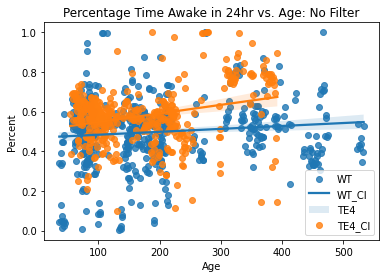

In [19]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 7)

sns.regplot(
    data = d[(d.State==1) & (d.Genotype=='wt')],
    x = 'Age',
    y = 'Time',
);

sns.regplot(
    data = d[(d.State==1) & (d.Genotype=='te4')],
    x = 'Age',
    y = 'Time',
);

plt.legend(['WT', 'WT_CI', 'TE4', 'TE4_CI'])
plt.ylabel('Percent')
plt.title('Percentage Time Awake in 24hr vs. Age: No Filter')

In [30]:
dnew = d.groupby(['Genotype', 'State']).mean()
dnew

,Animal,Age,State,Time,Genotype,Date
0,CAF00022,63,1,0.558796,te4,2020-04-20 12:07:45
1,CAF00022,63,2,0.388241,te4,2020-04-20 12:07:45
2,CAF00022,63,3,0.052963,te4,2020-04-20 12:07:45
3,CAF00022,64,1,0.627659,te4,2020-04-21 12:07:45
4,CAF00022,64,2,0.316796,te4,2020-04-21 12:07:45
...,...,...,...,...,...,...
2997,KDR00036,151,2,0.701349,wt,2022-04-01 13:12:41
2998,KDR00036,151,3,0.049472,wt,2022-04-01 13:12:41
2999,KDR00036,153,1,0.142976,wt,2022-04-03 11:37:39
3000,KDR00036,153,2,0.822719,wt,2022-04-03 11:37:39


## Outliers

In [23]:
d_wake = d[d.State == 1]
outliers = d_wake[(d_wake.Time > .8) | (d_wake.Time < .2)]
outliers[outliers.Age > 300]

,Animal,Age,State,Time,Genotype,Date
390,CAF00037,373,1,0.862500,te4,2020-08-25 17:10:48
433,CAF00037,391,1,0.893545,te4,2020-09-12 13:46:41
435,CAF00037,392,1,0.144246,te4,2020-09-13 14:46:41
1597,CAF00062,365,1,0.143908,te4,2020-11-17 16:14:39
1603,CAF00062,368,1,0.828530,te4,2020-11-20 10:06:19
1627,CAF00069,369,1,0.869557,wt,2021-01-08 13:50:10
1630,CAF00069,370,1,0.812033,wt,2021-01-09 16:50:10
1813,CAF00077,394,1,0.828333,wt,2021-02-02 14:28:24
1855,CAF00078,306,1,0.816191,te4,2021-02-20 17:09:56
1858,CAF00078,308,1,0.867130,te4,2021-02-22 10:09:56


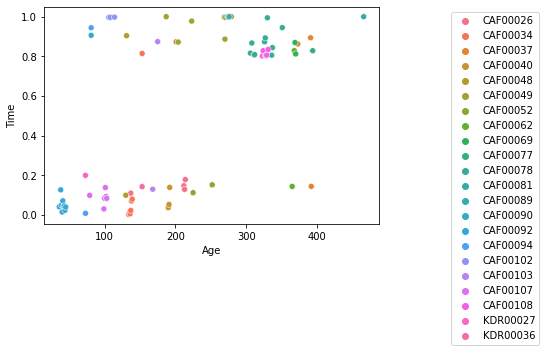

In [24]:
sns.scatterplot(
    data = outliers,
    x = 'Age',
    y = 'Time',
    hue = 'Animal' 
);
plt.gca().legend(bbox_to_anchor=(1.2, 1))
outliers.to_csv('./data/outliers.csv')

In [25]:
outlier_animals = ['CAF00090', 'CAF00092', 'CAF00094', 'CAF00095']
d_wake = d_wake[~d_wake.Animal.isin(outlier_animals)]
d_wake

,Animal,Age,State,Time,Genotype,Date
0,CAF00022,63,1,0.558796,te4,2020-04-20 12:07:45
3,CAF00022,64,1,0.627659,te4,2020-04-21 12:07:45
6,CAF00022,65,1,0.664537,te4,2020-04-22 12:07:45
9,CAF00022,66,1,0.455787,te4,2020-04-23 12:07:45
12,CAF00022,67,1,0.249444,te4,2020-04-24 12:07:45
...,...,...,...,...,...,...
2987,KDR00036,148,1,0.317199,wt,2022-03-29 13:51:26
2990,KDR00036,149,1,0.265424,wt,2022-03-30 08:51:26
2993,KDR00036,150,1,0.265211,wt,2022-03-31 11:58:37
2996,KDR00036,151,1,0.249179,wt,2022-04-01 13:12:41


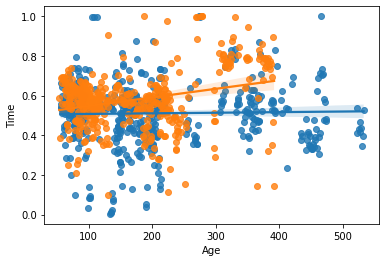

In [26]:
sns.regplot(
    data = d_wake[d_wake.Genotype=='wt'],
    x = 'Age',
    y = 'Time',
);

sns.regplot(
    data = d_wake[d_wake.Genotype=='te4'],
    x = 'Age',
    y = 'Time',
);

In [27]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


## QQ-plot

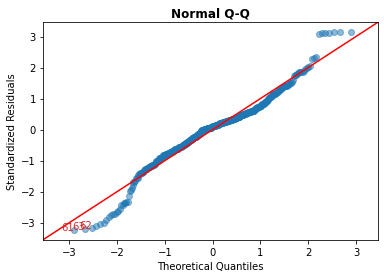

In [28]:
dwt = d_wake[d_wake.Genotype == 'wt']
res = statsmodels.formula.api.ols(formula= "Time ~ Age", data=dwt).fit()
cls = LinearRegDiagnostic(res)
cls.qq_plot();

## Leverage

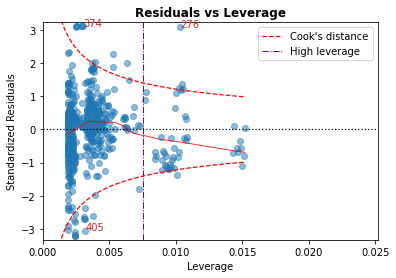

In [29]:
cls.leverage_plot(high_leverage_threshold=True, cooks_threshold='dof');

## Residual

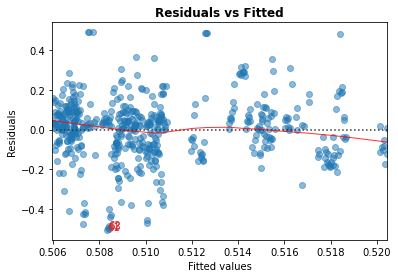

In [30]:
cls.residual_plot();

## Influential Points

In [31]:
#create instance of influence
influence = res.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d = influence.cooks_distance

In [32]:
leverage_mask = leverage < 1
cooks_d_mask = cooks_d[0] < 4 / dwt.shape[0] # dof criterion


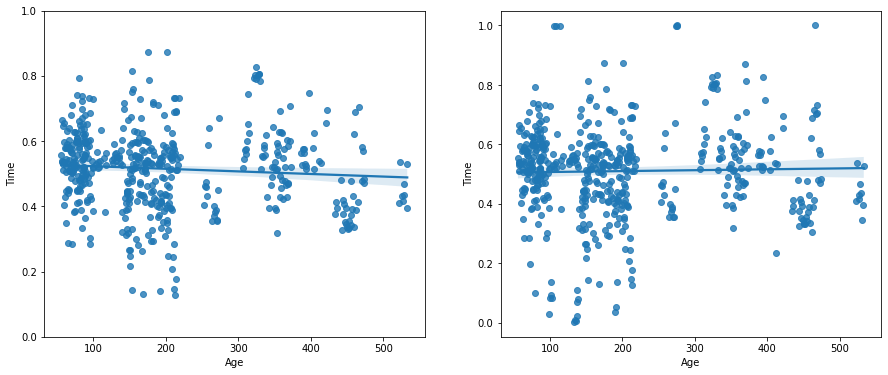

In [33]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
sns.regplot(
    data = dwt[leverage_mask & cooks_d_mask],
    x = 'Age',
    y = 'Time',
    ax = axs[0],
);
axs[0].set_ylim(0, 1)
sns.regplot(
    data = dwt,
    x = 'Age',
    y = 'Time',
    ax = axs[1]
);

## TE4 Animals

(0.0, 1.0)

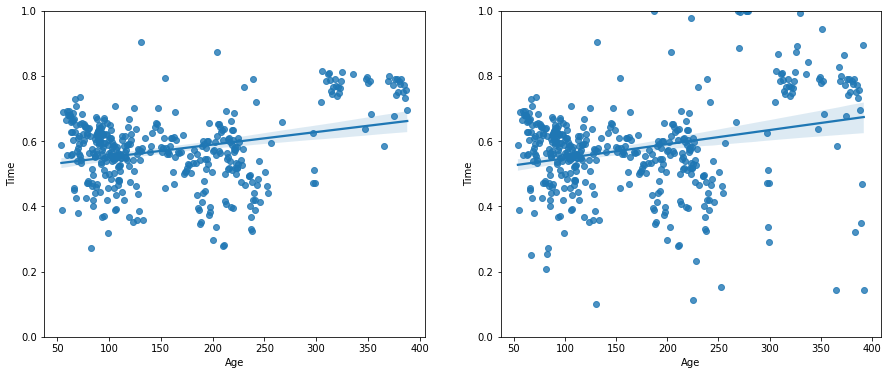

In [34]:
dwt = d_wake[d_wake.Genotype == 'te4']
res = statsmodels.formula.api.ols(formula= "Time ~ Age", data=dwt).fit()
influence = res.get_influence()
cooks_d = influence.cooks_distance
cooks_d_mask = cooks_d[0] < 4 / dwt.shape[0] # dof criterion
fig, axs = plt.subplots(1,2,figsize=(15,6))
sns.regplot(
    data = dwt[cooks_d_mask],
    x = 'Age',
    y = 'Time',
    ax = axs[0],
);
axs[0].set_ylim(0, 1)
sns.regplot(
    data = dwt,
    x = 'Age',
    y = 'Time',
    ax = axs[1]
);
axs[1].set_ylim(0, 1)

In [43]:
d.Animal[d.Genotype=='wt'].unique().shape

(28,)